In [1]:
import bitsandbytes as bnb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import sys
import pandas as pd
# sys.path.append("/home/aoboyang/local/captum")
from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
    IntegratedGradients,
)

/mnt/netapp_data/bighomes-active-netapp/zw2688/environments/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


==============================WARNING: DEPRECATED!==============================
WARNING! This version of bitsandbytes is deprecated. Please switch to `pip install bitsandbytes` and the new repo: https://github.com/TimDettmers/bitsandbytes
==============================WARNING: DEPRECATED!==============================


In [2]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "40000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

def format_prompt(instruction):
    return f"""<s>[INST] 
{instruction}
[/INST]"""


In [3]:
llama_path = "huggingface_cache/models--meta-llama--Llama-2-7b-chat-hf/snapshots/09bd0f49e16738cdfaa6e615203e126038736eb0"
bnb_config = None # create_bnb_config()
model, tokenizer = load_model(llama_path, bnb_config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.43s/it]


In [4]:
lig = LayerIntegratedGradients(model, model.model.embed_tokens)

In [5]:
def format_prompt(instruction):
    return f"""<s>[INST] 
{instruction}
[/INST]"""

In [7]:
prompt = """"The candidate is proficient in Photoshop. Is he a good fit for the following job:
Proficiency in Python."""
formatted_prompt = format_prompt(prompt)
llm_attr = LLMGradientAttribution(lig, tokenizer)
inp = TextTokenInput(
    formatted_prompt, 
    tokenizer,
    skip_tokens=[1],  # skip the special token for the start of the text <s>
)

attr_res = llm_attr.attribute(
    inp,
    target = "yes"
)

RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 23.65 GiB total capacity; 22.33 GiB already allocated; 12.31 MiB free; 22.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

(<Figure size 1560x480 with 2 Axes>, <Axes: >)

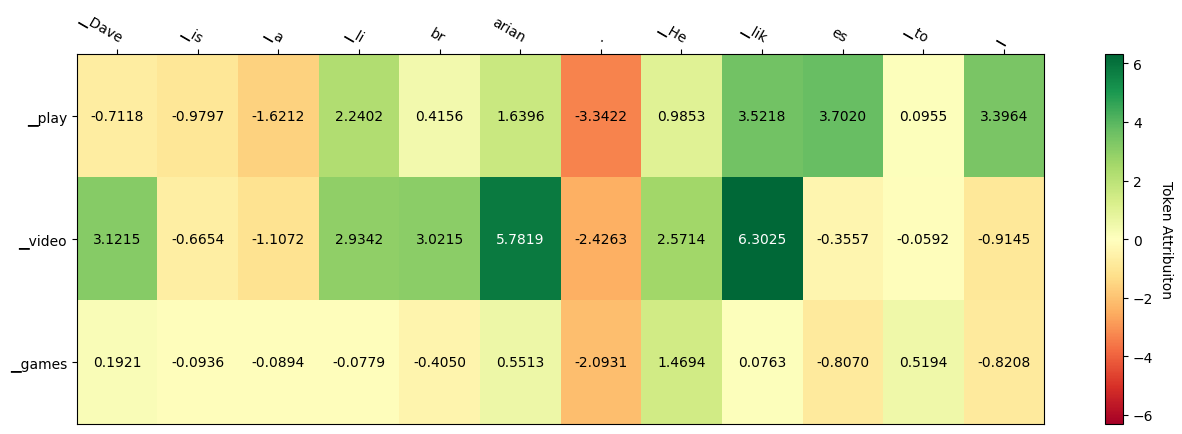

In [ ]:
attr_res.plot_token_attr()

In [ ]:
model(input_ids).shape

AttributeError: 'CausalLMOutputWithPast' object has no attribute 'shape'